<a href="https://colab.research.google.com/github/jonnythebard/tf2_workbook/blob/master/cnn_spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, MaxPool1D, Embedding, Conv1D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.0.0


In [2]:
# download example data
!wget https://lazyprogrammer.me/course_files/spam.csv

--2019-12-16 09:20:02--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 104.31.81.48, 2606:4700:30::681f:5130, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K   812KB/s    in 0.6s    

2019-12-16 09:20:04 (812 KB/s) - ‘spam.csv’ saved [503663/503663]



In [3]:
# load in the data
df = pd.read_csv("spam.csv", encoding="ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# rename columns to something better
df.columns = ["labels", "data"]
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
# create binary labels
df["b_labels"] = df["labels"].map({"ham": 0, "spam": 1})
Y = df["b_labels"].values

In [0]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df["data"], Y, test_size=0.33)

In [8]:
# tokenize & index the sentences
MAX_VOCAB_SIZE = 200000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

word2idx = tokenizer.word_index
V = len(word2idx)
print(f"Found {V} unique tokens")

Found 7265 unique tokens


In [9]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print(f"shape of data train tensor: {data_train.shape}")

# get sequence length
T = data_train.shape[1]

shape of data train tensor: (3733, 189)


In [10]:
# pad test sequences
data_test = pad_sequences(sequences_test, maxlen=T)
print(f"shape of data test tensor: {data_test.shape}")

shape of data test tensor: (1839, 189)


In [11]:
# build the cnn model
D = 20

i = Input(shape=(T, ))
x = Embedding(V + 1, D)(i)
x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPool1D(3)(x)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPool1D(3)(x)
x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
x = MaxPool1D(3)(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(i, x)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 189)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 189, 20)           145320    
_________________________________________________________________
conv1d (Conv1D)              (None, 187, 32)           1952      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 62, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 128)           24704 

In [12]:
r = model.fit(data_train, Ytrain, epochs=10, validation_data=(data_test, Ytest))

Train on 3733 samples, validate on 1839 samples
Epoch 1/10
3733/3733 [==============================] - 7s 2ms/sample - loss: 0.3671 - accuracy: 0.8744 - val_loss: 0.1142 - val_accuracy: 0.9657
Epoch 2/10
3733/3733 [==============================] - 1s 288us/sample - loss: 0.0693 - accuracy: 0.9810 - val_loss: 0.0470 - val_accuracy: 0.9875
Epoch 3/10
3733/3733 [==============================] - 1s 278us/sample - loss: 0.0163 - accuracy: 0.9957 - val_loss: 0.0469 - val_accuracy: 0.9875
Epoch 4/10
3733/3733 [==============================] - 1s 283us/sample - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.0528 - val_accuracy: 0.9908
Epoch 5/10
3733/3733 [==============================] - 1s 283us/sample - loss: 7.8423e-04 - accuracy: 1.0000 - val_loss: 0.0615 - val_accuracy: 0.9913
Epoch 6/10
3733/3733 [==============================] - 1s 285us/sample - loss: 0.0017 - accuracy: 0.9992 - val_loss: 0.0692 - val_accuracy: 0.9880
Epoch 7/10
3733/3733 [==============================] - 1s 277

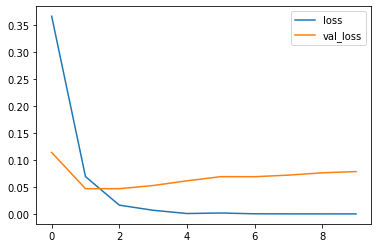

In [13]:
# plot the loss
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()

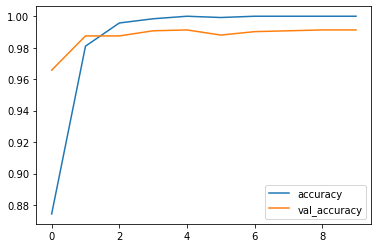

In [14]:
# plot the accuracy
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend()